<a href="https://colab.research.google.com/github/JRKagumba/2D-video-based-exercise-classification/blob/main/notebooks/03_XGB_Feature_Generation_and_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Install libraries

In [16]:
!pip install cesium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import os
import cesium
import xgboost as xgb
import numpy as np
import pandas as pd

from cesium import featurize as ft
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [18]:
PROJ_WORKOUTS_ROOT = os.path.join('/content/gdrive/MyDrive/ColabNotebooks/BiomechanicsAnalysis/___WORKOUTS/data/processed')

workout_types = os.listdir(PROJ_WORKOUTS_ROOT)

data_dict = {
    'burpees':[],
    'jumping_jacks':[],
    'mountain_climbers':[],
    'pushups':[],
    'squats':[]
}

joint_angles_list = ['L_ELB',	'R_ELB',
                     'L_SHO','R_SHO',
                     'L_HIP','R_HIP',
                     'L_KNE','R_KNE']

### Load in Dataframes

In [19]:
for workout_type in workout_types:
    workout_samples = os.listdir(os.path.join(PROJ_WORKOUTS_ROOT, workout_type)) 
    for sample in workout_samples:
        sample_csv_path = os.path.join(PROJ_WORKOUTS_ROOT, workout_type, sample, f'{sample}_joint_angles.csv')

        df = pd.read_csv(sample_csv_path)
        data_dict[workout_type].append(df)

### Convert Joint Angle Data Vector into Numpy Array

In [20]:
JA_df_dict = {}

for joint_angle in joint_angles_list:

    dataframe_lst = []

    for key, value_lst in data_dict.items():
        for df in value_lst:
            dataframe_lst.append(
                {   
                'times' : df.index.to_numpy(), 
                'values' : df[joint_angle].to_numpy(), 
                'classes' : key
                }
            )

    JA_df_dict[joint_angle] = pd.DataFrame(dataframe_lst)

### Get rid of rows with values of size 0

Looks like only index 86 has a value and time of 0... we will drop it

In [21]:
for ind in JA_df_dict['L_ELB'].index[84:89]:
    print(f"Index:{ind}, {np.size(JA_df_dict['L_ELB']['times'][ind]):<10}, {np.size(JA_df_dict['L_ELB']['values'][ind]):<10}, {np.size(JA_df_dict['L_ELB']['classes'][ind]):<10}")

Index:84, 536       , 536       , 1         
Index:85, 589       , 589       , 1         
Index:86, 0         , 0         , 1         
Index:87, 833       , 833       , 1         
Index:88, 298       , 298       , 1         


In [22]:
for key in JA_df_dict.keys():
    JA_df_dict[key] = JA_df_dict[key].drop([86])

for ind in JA_df_dict['L_ELB'].index[84:89]:
    print(f"Index:{ind}, {np.size(JA_df_dict['L_ELB']['times'][ind]):<10}, {np.size(JA_df_dict['L_ELB']['values'][ind]):<10}, {np.size(JA_df_dict['L_ELB']['classes'][ind]):<10}")

Index:84, 536       , 536       , 1         
Index:85, 589       , 589       , 1         
Index:87, 833       , 833       , 1         
Index:88, 298       , 298       , 1         
Index:89, 138       , 138       , 1         


### Convert all Dataframes to Dicts  (this is the format cesium likes for feature generation)

In [23]:
for key in JA_df_dict.keys():

    JA_df_dict[key] = JA_df_dict[key].to_dict()

    times = [value for value in JA_df_dict[key]['times'].values()]
    values = [value for value in JA_df_dict[key]['values'].values()]
    classes = np.array([value for value in JA_df_dict[key]['classes'].values()])


    JA_df_dict[key]['times'] = times
    JA_df_dict[key]['values'] = values
    JA_df_dict[key]['classes'] = classes

### Create a dict of features for each joint angle time series set

In [24]:
features_to_use = [    
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average"]

features_df_dict = {}

for key in JA_df_dict.keys():

    features_df_dict[key] = ft.featurize_time_series(times=JA_df_dict[key]['times'],
                                              values=JA_df_dict[key]["values"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler=None)
    
    features_df_dict[key]['classes'] = JA_df_dict[key]['classes']
    features_df_dict[key].columns =  features_df_dict[key].columns.droplevel(-1)

features_df_dict['L_ELB'].head(3)

feature,amplitude,percent_beyond_1_std,maximum,max_slope,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,classes
0,54.32,0.24,179.02,19.66,155.17,12.42,0.44,70.37,-1.01,30.85,141.22,burpees
1,89.61,0.18,179.31,149.00,147.36,18.73,0.48,0.09,-1.22,40.66,130.16,burpees
2,85.72,0.37,171.91,80.36,130.82,31.75,0.22,0.46,-0.69,45.59,117.39,burpees


### Train XGB Model

In [25]:
joint_name = []
training_score = []
testing_score = []


feature_importance = []

joint_model = {}

def model_training(df, joint):

    X_train, X_test, y_train, y_test = train_test_split(
        df.iloc[:, :11].values, df["classes"], test_size=0.2)
    
    model = xgb.XGBClassifier(n_estimators=25, max_depth=25) #random_state=16                  
    model.fit(X_train, y_train)

    joint_model[joint] = model

    perm_importance = permutation_importance(model, X_test, y_test)

    joint_name.append(joint)
    training_score.append(model.score(X_train, y_train))
    testing_score.append(model.score(X_test, y_test))

    feature_importance.append(perm_importance)
    # feature_importance.append(perm_importance.importances_mean.argsort())

    # print(f"Joint:{joint:<15}, Train_Score:{model.score(X_train, y_train):<15}, Test_Score:{model.score(X_test, y_test):<15}")


for key in JA_df_dict.keys():
    model_training(features_df_dict[key], key)


pd.options.display.float_format = "{:,.2f}".format
df_results = pd.DataFrame([joint_name, training_score, testing_score])
df_results = df_results.transpose()
df_results = df_results.rename(columns={0:'Joint',1:'Training Score',2:'Testing Score'}).sort_values(by='Testing Score',ascending=False)
df_results

,Joint,Training Score,Testing Score
3,R_SHO,0.99,0.86
4,L_HIP,1.00,0.86
2,L_SHO,0.99,0.79
6,L_KNE,0.99,0.79
7,R_KNE,1.00,0.79
5,R_HIP,1.00,0.75
0,L_ELB,1.00,0.68
1,R_ELB,1.00,0.54


In [26]:
feature_map_dict = {
0 : "amplitude",
1 : "percent_beyond_1_std",
2 : "maximum",
3 : "max_slope",
4 : "median",
5 : "median_absolute_deviation",
6 : "percent_close_to_median",
7 : "minimum",
8 : "skew",
9 : "std",
10 : "weighted_average"
}


#Create a dict and df of important features
important_features_data_dict = {index :feature_importance[index]['importances_mean']   for index, _ in enumerate(joint_name)}
important_features_data_df = pd.DataFrame.from_dict(important_features_data_dict)

#Temp dict of Joint names
temp_dict = { index : value  for index, value in enumerate(joint_name)}

important_features_data_df= important_features_data_df.rename(temp_dict, axis=1).rename(feature_map_dict, axis=0)
important_features_data_df

,L_ELB,R_ELB,L_SHO,R_SHO,L_HIP,R_HIP,L_KNE,R_KNE
amplitude,-0.02,0.00,0.15,0.00,0.00,0.02,0.06,0.15
percent_beyond_1_std,0.02,0.00,0.07,0.04,0.08,0.01,0.00,-0.01
maximum,0.00,0.04,0.04,0.01,0.02,0.17,0.03,0.06
max_slope,0.04,0.00,0.01,0.16,0.04,0.21,0.22,0.27
median,0.26,0.07,0.01,-0.01,0.09,0.01,0.00,0.04
median_absolute_deviation,0.00,0.00,0.00,0.12,0.04,0.00,0.00,0.11
percent_close_to_median,-0.01,0.02,-0.03,0.01,0.02,0.01,0.01,0.05
minimum,-0.07,0.08,0.19,0.13,0.12,0.01,-0.01,0.01
skew,-0.01,-0.02,0.01,0.00,0.01,0.00,0.00,0.07
std,0.19,0.15,0.00,0.00,0.03,0.25,0.07,0.00


### Plot Important Features per Joint

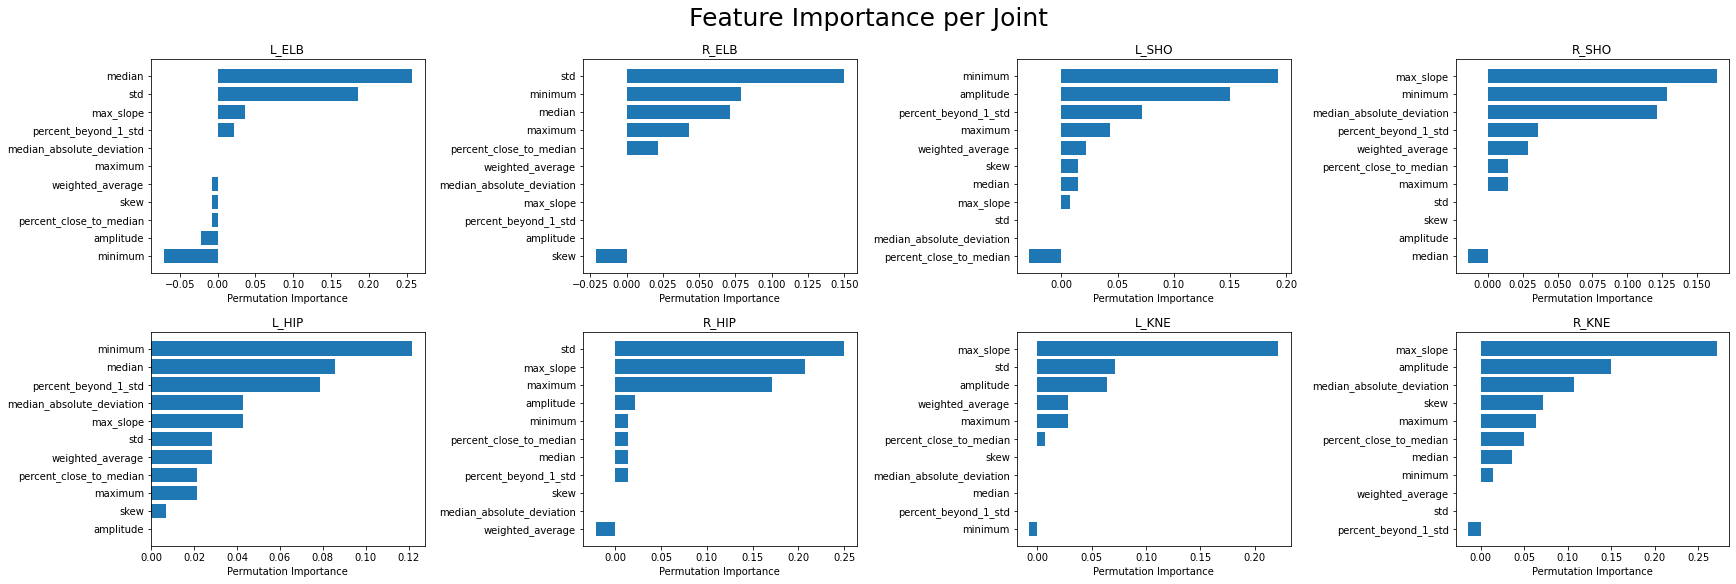

In [27]:
def plot_major_JA_feature_importance_as_array_of_subplots(df, plot_name):
    fig, axs = plt.subplots(2, 4, figsize=(24,8), constrained_layout=True)

    for ax, val in zip(axs.flat, df.columns):

        ax.set_title(f'{val}')
        ax.set_xlabel('Permutation Importance', fontsize=10)

        sorted_series = df[val].sort_values(ascending=True)
        # sorted_series = sorted_series.head(5)
        ax.barh(sorted_series.index, sorted_series, align='center')

    fig.suptitle(plot_name, fontsize=25)

plot_major_JA_feature_importance_as_array_of_subplots(important_features_data_df, 'Feature Importance per Joint')

### Plot Train-Test Scores

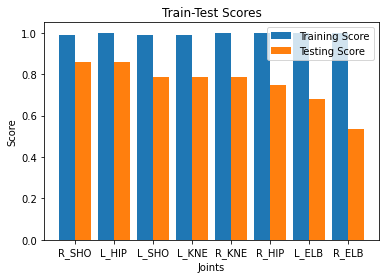

In [28]:
X_axis = np.arange(len(df_results))
  
plt.bar(X_axis - 0.2, df_results['Training Score'], 0.4, label = 'Training Score')
plt.bar(X_axis + 0.2, df_results['Testing Score'], 0.4, label = 'Testing Score')
  
plt.xticks(X_axis, df_results['Joint'])
plt.xlabel("Joints")
plt.ylabel("Score")
plt.title("Train-Test Scores")
plt.legend()
plt.show()

### Save Models for each Joint

In [31]:
MODEL_SAVE_PATH_ROOT = '/content/gdrive/MyDrive/ColabNotebooks/BiomechanicsAnalysis/___WORKOUTS/models/xgb'

for joint in joint_model.keys():

    save_path = os.path.join(MODEL_SAVE_PATH_ROOT, f"{joint}_model.json")
    joint_model[joint].save_model(save_path)   